# Data Dictionary

# 0.0 Imports

In [1]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
sns.set_style('darkgrid')

# 0.1 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [5]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [6]:
df_description.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Renaming Columns

In [7]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [8]:
df_description['description'] = df_description['description'].str.lower()

In [9]:
df_description.sort_values('invoice_date')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
143377,548698,84988,set of 72 pink heart paper doilies,2,1-Apr-17,1.45,18109.0,United Kingdom
143732,548711,20752,blue polkadot washing up gloves,1,1-Apr-17,2.10,18116.0,United Kingdom
143733,548711,22719,gumball monochrome coat rack,1,1-Apr-17,1.25,18116.0,United Kingdom
143734,548711,22467,gumball coat rack,4,1-Apr-17,2.55,18116.0,United Kingdom
143735,548711,85014A,black/blue polkadot umbrella,1,1-Apr-17,5.95,18116.0,United Kingdom
...,...,...,...,...,...,...,...,...
334723,566267,23293,set of 12 fairy cake baking cases,8,9-Sep-17,0.83,12647.0,Germany
334722,566267,23296,set of 6 tea time baking cases,8,9-Sep-17,1.25,12647.0,Germany
334721,566267,23295,set of 12 mini loaf baking cases,8,9-Sep-17,0.83,12647.0,Germany
334734,566268,22189,cream heart card holder,4,9-Sep-17,3.95,13813.0,Germany


## 1.2. Data Dimension

In [10]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [11]:
gu.sum_table(df_description)

,Name,dtypes,Uniques,Missing,Missing %
0,invoice_no,object,25900,0,0.00
1,stock_code,object,4070,0,0.00
2,description,object,4206,1454,0.27
3,quantity,int64,722,0,0.00
4,invoice_date,object,305,0,0.00
5,unit_price,float64,1630,0,0.00
6,customer_id,float64,4372,135080,24.93
7,country,object,38,0,0.00


## 1.4.  Handling Missing Values

Checking if there are invoice number of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [12]:
invoice_no_of_missing_customer_ids = df_description.query('customer_id.isnull()').invoice_no.values
df_description.loc[df_description.invoice_date.isin(invoice_no_of_missing_customer_ids)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


There are no invoice numbers in other parts of the dataset. So, in this cycle, I opted to remove the NAs and see how the model performs. In another cycle, I will find other ways to treat this.

In [13]:
# description
df_description = df_description.dropna(subset=['description', 'customer_id'], axis=0)
print(f'Removed data: {1 - (df_description.shape[0]/df_raw.shape[0]):.2%}')

Removed data: 24.93%


In [14]:
df_description.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5. Fixing Data Types

In [15]:
df_description.invoice_date = pd.to_datetime(df_description.invoice_date)
df_description.customer_id = df_description.customer_id.astype(int)

In [16]:
df_description.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom


In [17]:
df_description.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.6. Descriptive Statistics

In [18]:
num_att = df_description.select_dtypes(include=['float64', 'int64'])

In [19]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,61848.392291,248.693370,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,4804.591645,69.315162,452.219019,246924.542988


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Feature Engineering

In [20]:
df_feature = df_description.copy()

In [21]:
df_feature['gross_revenue'] = df_feature.quantity * df_feature.unit_price

# Recency
diff = df_feature.invoice_date.max() - df_feature.groupby('customer_id').max()['invoice_date']
recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

recency['recency'] = recency['recency'].dt.days
df_feature = df_feature.merge((recency), how='left', on='customer_id')


# Frequency
frequency = df_feature.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'frequency'})
df_feature = df_feature.merge((frequency), how='left', on='customer_id')

# Monetary
monetary = df_feature.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'monetary'})
df_feature = df_feature.merge((monetary), how='left', on='customer_id')

In [22]:
df_feature.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue,recency,frequency,monetary
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom,15.30,302,35,5288.63
1,536365,71053,white metal lantern,6,2016-11-29,3.39,17850,United Kingdom,20.34,302,35,5288.63
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom,22.00,302,35,5288.63
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom,20.34,302,35,5288.63
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom,20.34,302,35,5288.63


In [23]:
df_customers = df_feature.drop_duplicates('customer_id')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 3.0. Variables Filtering

In [24]:
df_rfm = df_feature.drop_duplicates('customer_id').copy()[['customer_id', 'recency', 'frequency', 'monetary']]
df_rfm.head()

,customer_id,recency,frequency,monetary
0,17850,302,35,5288.63
9,13047,31,18,3079.10
26,12583,2,18,7187.34
46,13748,95,5,948.25
65,15100,330,6,635.10


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [25]:
df_eda = df_rfm.copy()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [26]:
df_prep = df_eda.copy()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

In [27]:
df_fselect = df_prep.copy()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 7.0. Hyperparameter Fine-Tuning

In [34]:
X = df_fselect.drop(columns=['customer_id']).copy()

## 7.1 Within-Cluster Sum of Squares (WSS)

## 7.2 Sillhoutte Score

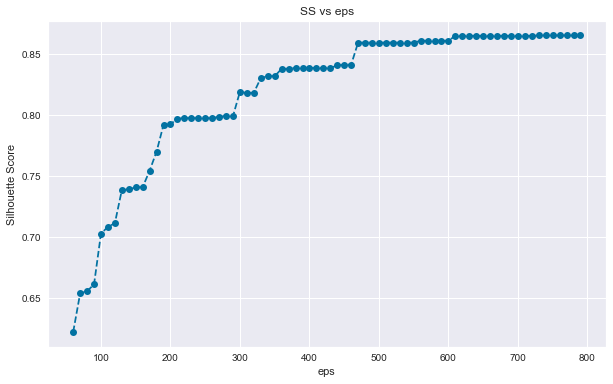

In [37]:
ss_list = []
eps_list = np.arange(60, 800, 10)
for k in eps_list:


    # model
    dbscan = DBSCAN(eps=k, min_samples=5)

    # model training
    labels = dbscan.fit_predict(X)
    ss = mt.silhouette_score(X, labels)
    ss_list.append(ss)

plt.figure(figsize=(10, 6))
plt.plot(eps_list, ss_list, linestyle='--', marker='o', color='b')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('SS vs eps');

In [41]:
len(np.unique(labels))

3

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. DBSCAN

In [45]:
#kmeans = KMeans(init='random', n_clusters=clusters, n_init=10, max_iter=300, random_state=42)
dbscan = DBSCAN(eps=800, min_samples=5)
labels = dbscan.fit_predict(X)

print(f'Number of clusters: {len(np.unique(labels))}')
ss = mt.silhouette_score(X, labels)
print(f'Silhouette Score: {ss}')

Number of clusters: 3
Silhouette Score: 0.8647895382223605


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [46]:
cluster_df = df_fselect.copy()

cluster_df['cluster'] = labels

In [47]:
px.scatter_3d(x='recency', y='frequency', z='monetary', color='cluster', data_frame=cluster_df)

## 9.2. Clusters Profile

In [60]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = ((cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100).values
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency'].values
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency'].values
prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary'].values

In [61]:
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,avg_monetary
0,-1,44,1.006404,14.613636,54.704545,55952.688409
1,0,4318,98.764867,92.562761,4.498379,1313.846775
2,1,10,0.228728,6.400000,35.900000,16495.715000


## 9.3 Report

Cluster -1

    - Number of Customers: 44
    - Percentage of Customers: 1.01%
    - Average Recency: 14.61 
    - Average Frequency: 54.7
    - Average Monetary: 55,952.68

Cluster 1

    - Number of Customers: 31
    - Percentage of Customers: 0.23%
    - Average Recency: 6.4 
    - Average Frequency: 35.9
    - Average Monetary: 16,495.72

Cluster 0

    - Number of Customers: 4318
    - Percentage of Customers: 98.76%
    - Average Recency: 92.56 
    - Average Frequency: 4.5
    - Average Monetary: 1,313.85

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Deploy to Production